2018 Oct 6<br>
Setting up an analysis of Kepler-76 b using DFM's emcee package

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import bindata, transit_duration
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import emcee
from emcee.autocorr import integrated_time

import dill

K76 = Kepler76_params()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846894


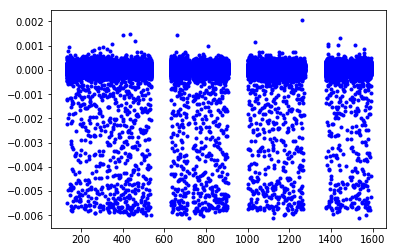

In [5]:
# Initial fit using Faigler's parameters (with my own T0)
plt.plot(filtered_time, filtered_flux, 'b.')

In [14]:
def fit_all_signals(cur_time, cur_p, cur_b, cur_T0, cur_Aellip, cur_Abeam, cur_F0, cur_Aplanet, cur_phase_shift):
    params = K76.saved_params.copy()
    
    params['p'] = cur_p
    params['b'] = cur_b
    params['T0'] = cur_T0
    params['Aellip'] = cur_Aellip
    params['Abeam'] = cur_Abeam
    params['F0'] = cur_F0
    params['Aplanet'] = cur_Aplanet
    params['phase_shift'] = cur_phase_shift
    
    cur_BC = BEER_curve(cur_time, params, supersample_factor=10, exp_time=30./60./24.)
    
    return cur_BC.all_signals()

CPU times: user 106 ms, sys: 42.5 ms, total: 149 ms
Wall time: 149 ms


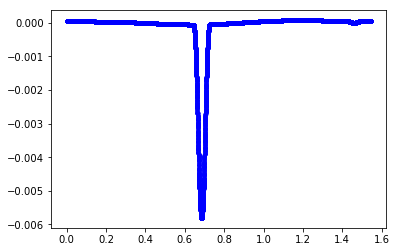

In [19]:
%time sig = fit_all_signals(folded_time, K76.saved_params['p'], K76.saved_params['b'], K76.saved_params['T0'], K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['F0'], K76.saved_params['Aplanet'], K76.saved_params['phase_shift'])
plt.plot(folded_time, sig ,'b.')

In [6]:
bounds = ([0., -1, K76.T0*0.95, -500e-6, -500e-6, -500e-6, -500e-6, -1], 
          [0.2, 1., K76.T0*1.05, 500e-6, 500e-6, 500e-6, 500e-6, 1])

def lnprior(theta):
    accept = True
    for i in range(len(theta)):
        accept = accept & (theta[i] > bounds[0][i] < theta[i] < bounds[1][i])

    if(accept):
        return 0.
    else:
        return -np.inf

def lnlike(theta, time, data, err):
    model = fit_all_signals(time, *theta)
    inv_sigma2 = 1.0/(err**2)
    return -0.5*(np.sum((data - model)**2*inv_sigma2))

def lnprob(theta, time, data, err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, time, data, err)

In [8]:
ind = ~transit_indices(folded_time, K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])

time = folded_time
data = filtered_flux
err = unbinned_noise*np.ones_like(folded_time)

initial_guess = [K76.saved_params['p'], K76.saved_params['b'], K76.saved_params['T0'],
                 K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['F0'], 
                 K76.saved_params['Aplanet'], K76.saved_params['phase_shift']]
popt, pcov = curve_fit(fit_all_signals, time, data, sigma=unbinned_noise*np.ones_like(time), p0=initial_guess, bounds=bounds)
uncertainty = np.sqrt(pcov.diagonal())

ndim, nwalkers = len(initial_guess), 100
pos = [popt + uncertainty*np.random.randn(ndim) for i in range(nwalkers)]

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time, data, err))
%time sampler.run_mcmc(pos, 5000)

print(np.std(sampler.chain[:, :, 0].reshape((-1, ndim))))

emcee: Exception while calling your likelihood function:
  params: [1.03614846e-01 9.56600026e-01 6.85004733e-01 1.49821553e-05
 7.98557467e-05 1.26838422e-05 5.28247212e-05 2.06333841e-01]
  args: (array([0.19340814, 0.21384281, 0.23427739, ..., 1.22867331, 1.24910778,
       1.26954245]), array([-4.66198749e-05, -1.05478890e-05,  9.01756952e-05, ...,
        1.81340286e-04, -1.30680958e-03, -2.17059615e-04]), array([0.00014346, 0.00014346, 0.00014346, ..., 0.00014346, 0.00014346,
       0.00014346]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/bjackson/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-6-76be7cf0b0f0>", line 23, in lnprob
    return lp + lnlike(theta, time, data, err)
  File "<ipython-input-6-76be7cf0b0f0>", line 15, in lnlike
    model = fit_all_signals(time, *theta)
  File "<ipython-input-4-00d3aaa417ad>", line 15, in fit_all_signals
    return cur_BC.all_signals()
  File "/Users/bjackson/anaconda2/lib/python2.7/site-packages/BEER_curve/BEER_curve.py", line 220, in all_signals
    transit = self._transit() - 1.
  File "/Users/bjackson/anaconda2/lib/python2.7/site-packages/BEER_curve/BEER_curve.py", line 180, in _transit
    return ma.evaluate(time)
  File "/Users/bjackson/anaconda2/lib/python2.7/site-packages/PyAstronomy/modelSuite/XTran/forTrans/mandelAgol.py", line 192, in evaluate
    self["p"], len(self._intrans))
KeyboardInterrupt


KeyboardInterrupt: 

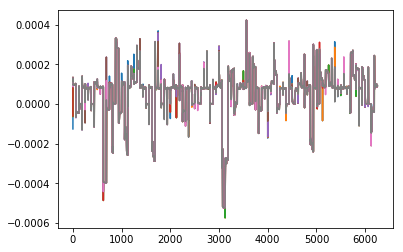

In [26]:
#dill.load_session('Analyzing_Kepler-76b_Using_Emcee.pkl')

plt.plot(sampler.chain[:,:,5].reshape((-1, ndim)) + sampler.chain[:,:,6].reshape((-1, ndim)))
#plt.plot(sampler.chain[:,:,3].reshape((-1, ndim)))
#plt.axhline(K76.phase_shift)

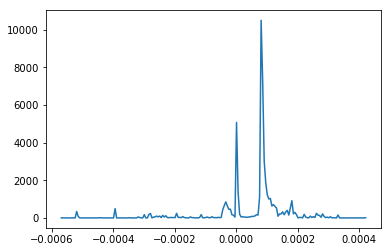

In [22]:
dist = sampler.chain[:,:,5].reshape((-1, ndim)) + sampler.chain[:,:,6].reshape((-1, ndim))
hst, bin_edges = np.histogram(dist, bins='auto')

plt.plot(bin_edges[1:], hst)

In [23]:
tm = integrated_time(dist)
print(tm)

AutocorrError: The chain is too short to reliably estimate the autocorrelation time